# Tutorial 1: Trajectory-Based Delay-Coordinate Invariant Measure Optimization for Parameter Identification of the Kuramoto--Sivashinsky Equation

In this tutorial, we use delay-coordiante invariant measures to perform parameter estimation of the partially observed Kuramoto--Sivashinsky equation, given by $u_{t} + \theta(u_{xx} + u_{xxxx}) + uu_x = 0,$
where $\theta\in [0.5,1.5].$ Given a partial observation $\{y(t_i;\theta^*)\}$ of the full state $\{u(t_i;\theta^*)\}$, we attempt to recover the parameter $\theta^*$. To accomplish this, we construct the delay-coordinate invariant measure $\hat{\mu}_y$ from the partially observed data and seek to minimize $\mathcal{D}(\hat{\mu}_y,\hat{\mu}_y(\theta))$ where $\hat{\mu}_y(\theta)$ is the simulated delay-coordinate invariant measure for parameter $\theta \in [0.5,1.5]$ and $\mathcal{D}$ is a metric or divergence over the space of probability measures.

We begin by importing the relevant packages.

In [11]:
pip install pot #Python Optimal Transport for computing the sliced Wasserstein distance

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from ot.sliced import sliced_wasserstein_distance
from scipy.optimize import minimize
import jax
import jax.numpy as jnp

The following code, slightly modified from [machine-learning-and-simulation](https://github.com/Ceyron/machine-learning-and-simulation?tab=MIT-1-ov-file) by Felix Kohler, uses an exponential time-differencing scheme to generate a solution $\{u(t_i;\theta)\}$ to the Kuramoto--Sivashinsky equation for a given parameter $\theta$.

In [13]:
dt = 0.1
freq = 30
num_steps = int(1e5)
DOMAIN_SIZE = 100.0
N_DOF = 200
mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)

class KuramotoSivashinsky():
        def __init__(
            self,
            L,
            N,
            dt,
            theta
        ):
            self.L = L
            self.N = N
            self.dt = dt
            self.dx = L / N

            wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
            self.derivative_operator = 1j * wavenumbers


            linear_operator = - theta* self.derivative_operator**2 - theta* self.derivative_operator**4
            self.exp_term = jnp.exp(dt * linear_operator)
            self.coef = jnp.where(
                linear_operator == 0.0,
                dt,
                (self.exp_term - 1.0) / linear_operator,
            )

            self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))

        def __call__(
            self,
            u,
        ):
            u_nonlin = - 0.5 * u**2
            u_hat = jnp.fft.rfft(u)
            u_nonlin_hat = jnp.fft.rfft(u_nonlin)
            u_nonlin_hat = self.alias_mask * u_nonlin_hat
            u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

            u_next_hat = self.exp_term * u_hat + self.coef * u_nonlin_der_hat
            u_next = jnp.fft.irfft(u_next_hat, n=self.N)
            return u_next

def KS_trajectory(theta):
        u_0 = jnp.sin( 2* jnp.pi * mesh / DOMAIN_SIZE)
        ks_stepper = KuramotoSivashinsky(
            L=DOMAIN_SIZE,
            N=N_DOF,
            dt=dt,
            theta = theta)
        ks_stepper = jax.jit(ks_stepper)
        u_current = u_0
        trj = [u_current, ]
        for i in range(num_steps-1):
            u_current = ks_stepper(u_current)
            trj.append(u_current)
        trj = jnp.stack(trj)
        return trj

We now use this solver to generate partially observed data $\{y(t_i;\theta^*)\}$ corresponding to the ground truth parameter $\theta ^*= 1$.

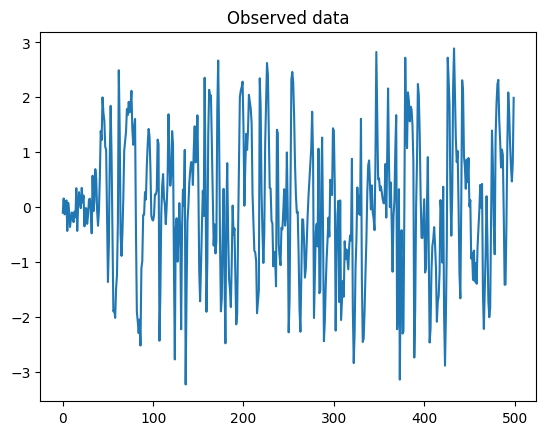

In [14]:
freq = 30 #sampling frequency
scale = 0.25 #noise scale
full = KS_trajectory(1)
obs = full[:,0][::freq]
noise = np.random.normal(0,scale,len(obs))
obs = obs+noise

plt.title('Observed data')
plt.plot(obs[:500])
plt.show()

Now, we construct the delay-coordinate invariant measure $\hat{\mu}_y$ out of the partially observed time-series. In what follows, we use a discrete time-delay of $\overline{\tau} = 1$ and embedding dimension of $d = 5$.

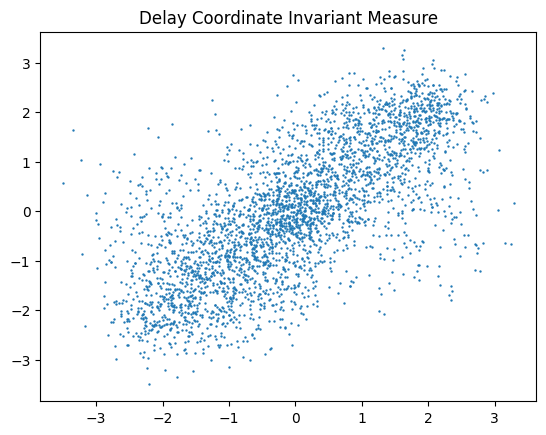

In [15]:
dim = 5
tau = 1

def delay(X,dim,tau):
    new = np.zeros((len(X)-tau*dim,dim))
    for i in range(dim):
        new[:,i] = X[dim*tau-(i+1)*tau:-(1+i)*tau]
    return new

obs_delayed = delay(obs,dim,tau)

plt.title('Delay Coordinate Invariant Measure')
plt.scatter(obs_delayed[:,0],obs_delayed[:,1],s = 0.5)
plt.show()

We now define our objective function $\mathcal{J}(\theta) = \mathcal{D}(\hat{\mu}_y,\hat{\mu}_y(\theta))$, which uses the sliced Wasserstein distance to compare a simulated delay-coordinate invariant measure $\hat{\mu}_y(\theta)$, given the current guess $\theta\in [0.5,1.5]$, with the observed delay-coordiante invariant measure $\hat{\mu}_y$.

In [16]:
def cost(theta):
    s1 = obs_delayed #observed delay-coordinate invariant measure
    s2 = delay(KS_trajectory(theta)[:,0][::freq],dim,tau) #simulated delay-coordinate invariant measure
    return sliced_wasserstein_distance(s1,s2)

We can now use the Nelder--Mead algorithm to perform optimization of this objective function, starting with an initial guess of $\theta_0 = 0.75.$

In [17]:
params = []
c = 0
def callback(x):
    global c
    c+= 1
    print('Iteration: ', c ,'| Parameter: ', x)
    params.append(x)

res = minimize(cost, [0.75], method='Nelder-Mead', bounds = [(0.5,1.5)],callback = callback,options={'maxiter': 15, 'disp': True})

Iteration:  1 | Parameter:  [0.8625]
Iteration:  2 | Parameter:  [1.0125]
Iteration:  3 | Parameter:  [1.0125]
Iteration:  4 | Parameter:  [1.05]
Iteration:  5 | Parameter:  [1.03125]
Iteration:  6 | Parameter:  [1.03125]
Iteration:  7 | Parameter:  [1.03125]
Iteration:  8 | Parameter:  [1.0265625]
Iteration:  9 | Parameter:  [1.0265625]
Iteration:  10 | Parameter:  [1.0265625]
Iteration:  11 | Parameter:  [1.0265625]
Iteration:  12 | Parameter:  [1.0265625]
Iteration:  13 | Parameter:  [1.0265625]
Iteration:  14 | Parameter:  [1.0265625]


<ipython-input-17-733245085>:9: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(cost, [0.75], method='Nelder-Mead', bounds = [(0.5,1.5)],callback = callback,options={'maxiter': 15, 'disp': True})


After only 15 Nelder--Mead iterations, we infer the correct parameter $\theta^* = 1$ with reasonable accuracy.

In the next tutorial, we study an alternative strategy to performing data-driven system identification using delay-coordinate invariant measures which easily lends itself to gradient-based optimization over large-scale parameter spaces.  